In [1]:
!pip install fingerprint_enhancer

  Preparing metadata (setup.py) ... done
  Created wheel for fingerprint_enhancer: filename=fingerprint_enhancer-0.0.14-py3-none-any.whl size=10629 sha256=6c20c892977045a5b70723ffec353bad83b13cae55233259b6e29fb85e7482b7
  Stored in directory: /root/.cache/pip/wheels/3b/de/af/ea18bac41054916ac77ae32dfb8544155d758734b91266315d
Successfully built fingerprint_enhancer


In [2]:
!pip install fingerprint_feature_extractor

  Preparing metadata (setup.py) ... done
  Created wheel for fingerprint_feature_extractor: filename=fingerprint_feature_extractor-0.0.10-py3-none-any.whl size=4829 sha256=a14198bc756e34a18e51e2b2a3588ebc6dfb9f3794aded5bb079bb6956bdd92e
  Stored in directory: /root/.cache/pip/wheels/30/85/fd/31e1eefbb140c9a611a41c2819bd2186e1384c108eff4d10e1
Successfully built fingerprint_feature_extractor


## Reinstalarea opencv-contrib



In [4]:
!pip uninstall opencv-contrib-python opencv-python-headless -y

Found existing installation: opencv-contrib-python 4.11.0.86
Uninstalling opencv-contrib-python-4.11.0.86:
  Successfully uninstalled opencv-contrib-python-4.11.0.86
Found existing installation: opencv-python-headless 4.11.0.86
Uninstalling opencv-python-headless-4.11.0.86:
  Successfully uninstalled opencv-python-headless-4.11.0.86


In [5]:
!pip install opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.8 MB/s eta 0:00:00


In [6]:
from fingerprint_enhancer import enhance_fingerprint
import fingerprint_feature_extractor
import cv2
from google.colab import files
import numpy as np
from google.colab.patches import cv2_imshow
import ipywidgets as widgets
from skimage import data, color
from skimage.filters import threshold_otsu
from skimage.morphology import skeletonize
from skimage.util import invert

In [7]:
def extract_high_variance_blocks(image, n, variance_threshold):
    height, width = image.shape

    num_blocks_y = height // n
    num_blocks_x = width // n

    # List to store variances of all blocks
    variances = []

    # Iterate over blocks to calculate variances
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            # Extract the block
            y_start = i * n
            y_end = (i + 1) * n
            x_start = j * n
            x_end = (j + 1) * n
            block = image[y_start:y_end, x_start:x_end]

            # Calculate the variance of the block
            block_variance = np.var(block)
            variances.append((block_variance, (y_start, y_end, x_start, x_end, block)))

    # Calculate the mean and max variance of the image
    mean_variance = np.mean([v[0] for v in variances])
    max_variance = max([v[0] for v in variances])
    min_variance = min([v[0] for v in variances])

    print(f"Mean variance: {mean_variance}, Max variance: {max_variance}, Min variance: {min_variance}")

    if max_variance == mean_variance:
        print("All blocks have the same variance. Returning an empty list.")
        return []

    # Extract blocks with variance differing by the threshold and calculate gray values
    high_variance_blocks = []
    for block_variance, (y_start, y_end, x_start, x_end, block) in variances:
        variance_diff = block_variance - min_variance
        if variance_diff > variance_threshold:
            # Calculate the gray value for the block
            gray_value = int(((block_variance - (min_variance/variance_threshold)) / (max_variance - (min_variance/variance_threshold))) * 255)
            gray_value = max(0, min(255, gray_value))
            high_variance_blocks.append((y_start, y_end, x_start, x_end, block, gray_value))

    return high_variance_blocks

In [8]:
def perform_variance_segmentation(image, n=20, variance_threshold=100):
    blocks = extract_high_variance_blocks(image, n=n, variance_threshold = variance_threshold)

    height, width = image.shape

    # Initialize a new image filled with white
    segmented_image = np.full((height, width), 255, dtype=np.uint8)

    # Overlay the extracted blocks onto the segmented image
    for y_start, y_end, x_start, x_end, block, _ in blocks:
        segmented_image[y_start:y_end, x_start:x_end] = block

    return segmented_image

In [9]:
def perform_mean_shift_segmentation(image, spatial_radius=10, color_radius=20):
    # Convert the image to color if it's grayscale (Mean-Shift works on color images)
    print(spatial_radius)
    if len(image.shape) == 2:  # Grayscale image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Apply Mean-Shift filtering
    segmented_image = cv2.pyrMeanShiftFiltering(image, spatial_radius, color_radius)

    return segmented_image

In [10]:
def draw_fingerprint_features(image, FeaturesTerminations, FeaturesBifurcations):

    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Draw termination minutiae (red circles)
    for curr_minutiae in FeaturesTerminations:
        row, col = int(curr_minutiae.locY), int(curr_minutiae.locX)  # OpenCV uses (x, y) as (col, row)
        cv2.circle(color_image, (row, col), 4, (0, 0, 255), 1)  # Red circle

    # Draw bifurcation minutiae (blue circles)
    for curr_minutiae in FeaturesBifurcations:
        row, col = int(curr_minutiae.locY), int(curr_minutiae.locX)
        cv2.circle(color_image, (row, col), 4, (255, 0, 0), 1)  # Blue circle

    return color_image


Saving class3_Loop_0078.png to class3_Loop_0078.png
User uploaded file "class3_Loop_0078.png" with length 210175 bytes


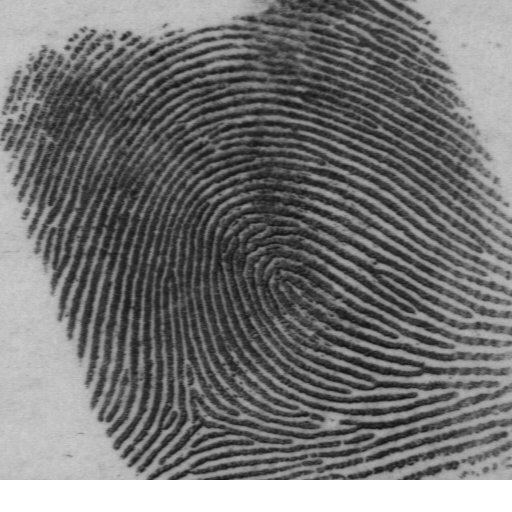

In [20]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  # Read the image using OpenCV
  img = cv2.imdecode(np.frombuffer(uploaded[fn], np.uint8), cv2.IMREAD_UNCHANGED)

  # Now you can work with the image, e.g., display it
  if img is not None:
      cv2_imshow(img) #If you are using colab
  else:
      print("Error: Could not read the image.")


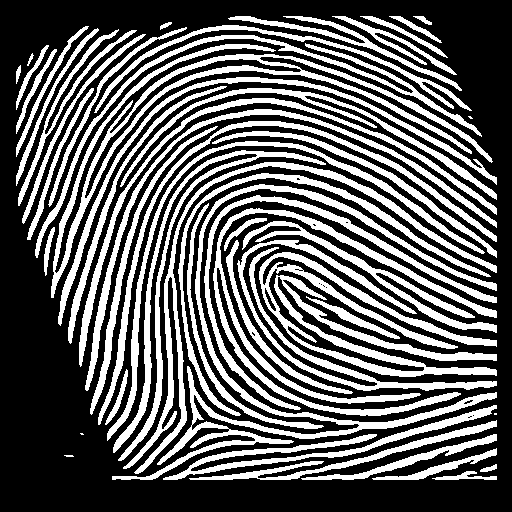

In [21]:
fp_enhanced_image = enhance_fingerprint(img)
fp_enhanced_image = (fp_enhanced_image * 255).astype(np.uint8)
cv2_imshow(fp_enhanced_image)

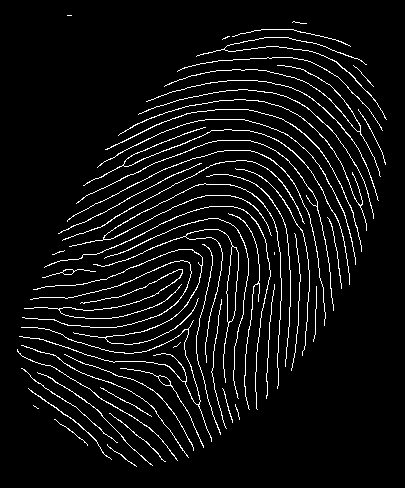

In [ ]:

fp_skeleton_image = cv2.ximgproc.thinning(fp_enhanced_image)
cv2_imshow(fp_skeleton_image)

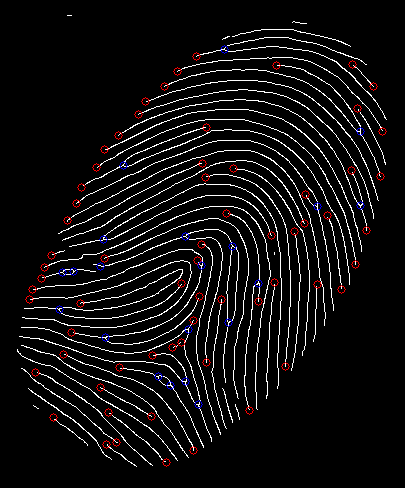

In [ ]:
FeaturesTerminations, FeaturesBifurcations = fingerprint_feature_extractor.extract_minutiae_features(fp_enhanced_image, spuriousMinutiaeThresh=10, invertImage=False, showResult=False, saveResult=False)

features_image = draw_fingerprint_features(fp_skeleton_image, FeaturesTerminations, FeaturesBifurcations)
cv2_imshow(features_image)